**Multi Layer Perceptron** para o **MNIST** by Ulian Gabriel


Esse dataset contém imagens com algarismos arábicos, de zero a nove, escritos a mão.

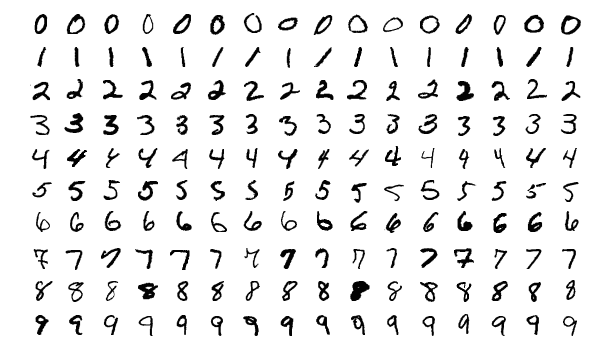



# Tarefa

Implementar uma rede neural multi layer perceptron para o MNIST.

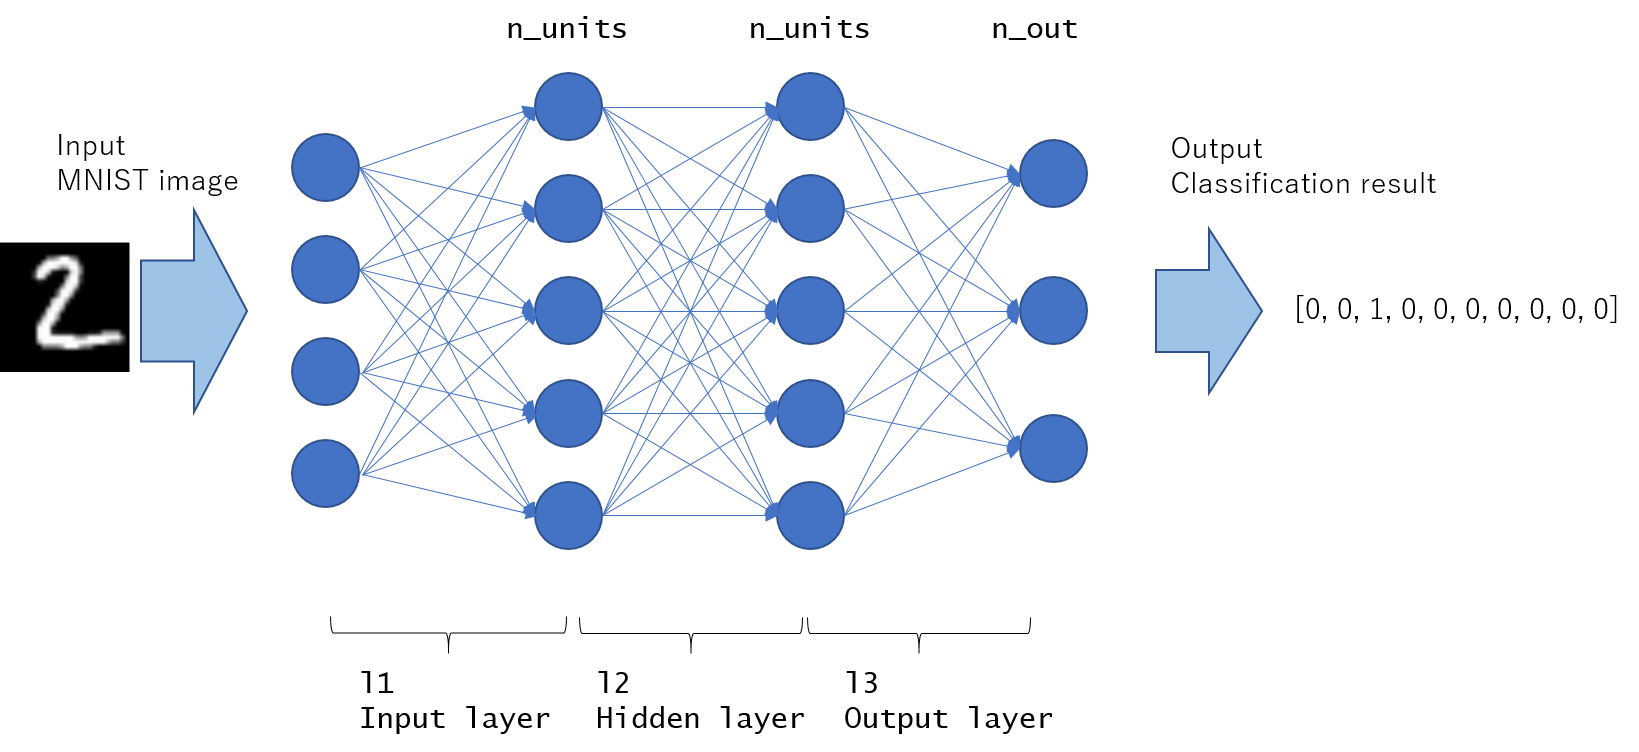

### Bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import sys

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

## Funções úteis

In [ ]:
def leaky_relu(input):
  return np.where(input > 0, input, input * 0.001)

def leaky_relu_deriv(input):
    return np.where(input > 0, 1, 0.01)

def softmax(input):
    tmp = np.exp(input - np.max(input))  # Subtrai o valor máximo
    output = tmp / np.sum(tmp)
    return output

def plot_digit(digit_data):
    digit_image = digit_data.reshape(8, 8)

    plt.imshow(digit_image, cmap='gray')
    plt.axis('off')
    plt.show()

def cross_entropy(prediction, target):
    epsilon = 1e-15  # Pequena constante para evitar log(0)
    prediction = np.clip(prediction, epsilon, 1 - epsilon)  # Evitar valores fora do intervalo [epsilon, 1-epsilon]
    perda = -np.sum(target * np.log(prediction))
    return perda

def absolute_error(prediction, target):
  return abs(prediction - target)

def accuracy(prediction, target):
  return int(prediction == target)

def displayLayer(layer):
  for i, perceptron in enumerate(layer):
    print(f"Perceptron {i + 1} weights: {perceptron.weights}")
    print(f"Perceptron {i + 1} bias: {perceptron.bias}")
    print()

## Preparação e separação dos dados

In [ ]:
digits = load_digits()
data = np.column_stack((digits.data, digits.target))

digits = data[:, :-1]  # Dados MNIST exceto rótulos
target = data[:, -1]   # Rótulos

data_train, data_test, target_train, target_test = train_test_split(digits, target, test_size=0.2, random_state=42)

print("Dados de treino: ", data_train.shape)
print("Rótulos de treino: ", target_train.shape)

print("Dados de teste: ", data_test.shape)
print("Rótulos de teste: ", target_test.shape)

Dados de treino:  (1437, 64)
Rótulos de treino:  (1437,)
Dados de teste:  (360, 64)
Rótulos de teste:  (360,)


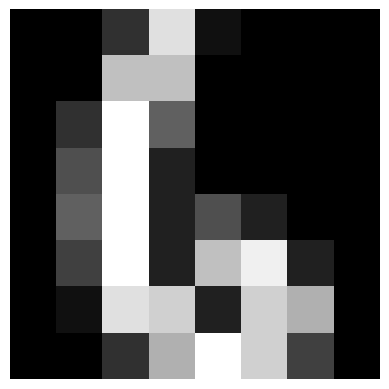

Índice 0: número 6


In [ ]:
index = 0

plot_digit(data_train[index])
target = int(target_train[index])

print(f"Índice {index}: número {target}")

## Classe Perceptron unitária

In [ ]:
class Perceptron:
  def __init__(self, input_size, output_layer = False):
    self.weights = np.random.normal(size = input_size)
    self.bias =  0
    self.output_layer = output_layer

  def predict(self, input):
    sum = np.dot(input, self.weights) + self.bias

    if self.output_layer:
        output = sum
    else:
        output = leaky_relu(sum)

    return output

  def setWeights(self, newWeights):
    self.weights = newWeights.copy()

  def setBias(self, newBias):
    self.bias = newBias.copy()

In [ ]:
def feedforward(digit, layer):

  activations = []

  for perceptron in layer:
    output = perceptron.predict(digit)
    activations.append(output)

  if layer[0].output_layer:
        return softmax(np.array(activations))

  return np.array(activations)

In [ ]:
def deltaCalc(prev_delta, layer, current_output):

  weights_matrix = np.array([perceptron.weights for perceptron in layer])

  temp = np.dot(prev_delta, weights_matrix)

  delta = [temp * leaky_relu_deriv(current_output)]

  return delta

In [ ]:
def backprop(layer, lr, prev_layer_output, delta):

    weights_matrix = np.array([perceptron.weights for perceptron in layer])

    prev_layer_output = prev_layer_output.reshape(1, -1)
    delta = delta.reshape(1, -1)

    weight_gradients = np.dot(prev_layer_output.T, delta)

    i = 0
    for perceptron in layer:
        perceptron.weights -= lr * weight_gradients.T[i]
        i += 1

    return layer

In [ ]:
network_input_size = data_train.shape[1] # 64 (8x8 MNIST)

layer1_size = 64
layer2_size = 32
output_size = 10 # Classes MNIST

layer1 = [Perceptron(network_input_size) for _ in range(layer1_size)]
layer2 = [Perceptron(layer1_size) for _ in range(layer2_size)]
outputLayer = [Perceptron(layer2_size, output_layer = True) for _ in range(output_size)]

## Vrau

In [ ]:
epochs = 50  # Número de épocas de treinamento
LRN_RATE = 0.001
acc_list = []

for epoch in range(epochs):

    total_loss = 0.0
    total_acc = 0.0
    local_acc = 0.0

    for digit, target in zip(data_train, target_train):

        # Feedforward
        layer1output = feedforward(digit, layer1)
        layer2output = feedforward(layer1output, layer2)
        finalOutput = feedforward(layer2output, outputLayer)

        # Cross Entropy para cálculo de perda
        loss = cross_entropy(np.argmax(finalOutput), target.astype(int))
        #loss = absolute_error(np.argmax(finalOutput), target.astype(int))
        total_loss += loss

        # Acurácia
        local_acc += accuracy(np.argmax(finalOutput), target.astype(int))

        error = finalOutput
        error[int(target)] -= 1

        # Backpropagation
        delta_saida = error
        delta_layer2 = deltaCalc(delta_saida, outputLayer, layer2output)
        delta_layer1 = deltaCalc(delta_layer2, layer2, layer1output)

        outputLayer = backprop(outputLayer, LRN_RATE, layer2output, delta_saida)
        layer2 = backprop(layer2, LRN_RATE, layer1output, delta_layer2[0])
        layer1 = backprop(layer1, LRN_RATE, digit, delta_layer1[0])

    total_acc = local_acc/len(data_train)
    acc_list.append(total_acc)
    # Cálculo da perda média durante a época
    average_loss = total_loss / len(data_train)
    print(f"Época {epoch + 1}/{epochs}, Perda Média: {average_loss:.10f}, Acurácia: {total_acc}")

Época 1/50, Perda Média: 2.5958161800, Acurácia: 0.38204592901878914
Época 2/50, Perda Média: 1.4421201000, Acurácia: 0.5748086290883786
Época 3/50, Perda Média: 1.0094840700, Acurácia: 0.6917188587334725
Época 4/50, Perda Média: 0.5528127050, Acurácia: 0.7703549060542797
Época 5/50, Perda Média: 0.8172013900, Acurácia: 0.8225469728601252
Época 6/50, Perda Média: 0.1442120100, Acurácia: 0.8608211551844119
Época 7/50, Perda Média: 0.6729893800, Acurácia: 0.8823938761308281
Época 8/50, Perda Média: 0.1442120100, Acurácia: 0.8823938761308281
Época 9/50, Perda Média: 0.1201766750, Acurácia: 0.9088378566457899
Época 10/50, Perda Média: 0.4326360300, Acurácia: 0.9151009046624913
Época 11/50, Perda Média: 0.0961413400, Acurácia: 0.918580375782881
Época 12/50, Perda Média: 0.6489540450, Acurácia: 0.9144050104384134
Época 13/50, Perda Média: 0.0240353350, Acurácia: 0.929714683368128
Época 14/50, Perda Média: 0.0000000000, Acurácia: 0.9345859429366736
Época 15/50, Perda Média: 0.0961413400, Acur

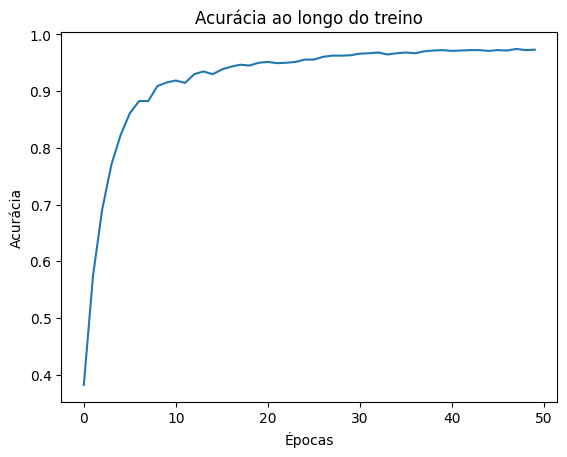

In [ ]:
plt.plot(range(epochs), acc_list)
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.title("Acurácia ao longo do treino")
plt.show()

## Teste da rede com o conjunto de dados de Teste

In [ ]:
acc_test = 0
predictions = []

for digit, target in zip(data_test, target_test):

    layer1output = feedforward(digit, layer1)
    layer2output = feedforward(layer1output, layer2)
    finalOutput = feedforward(layer2output, outputLayer)

    prediction = np.argmax(finalOutput)
    predictions.append(prediction)

    acc_test += accuracy(prediction, target.astype(int))

print('Acurácia no teste: ' + str((acc_test/target_test.shape[0]) * 100) + '%')

Acurácia no teste: 96.11111111111111%


## Matriz de Confusão

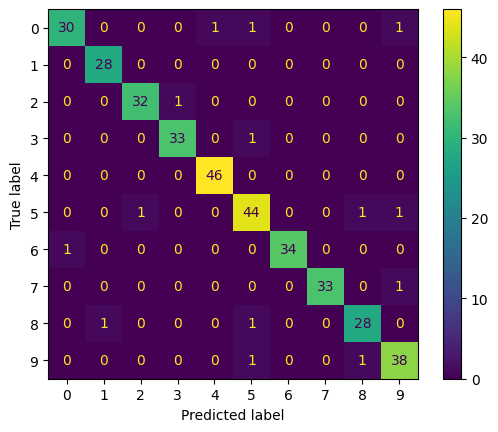

In [ ]:
cm = confusion_matrix(target_test, predictions)
cm_display = ConfusionMatrixDisplay(cm).plot()